__Some ways of forecasting hotels' revenue (*)__ 

- based on guests (object is a guest, should have id of guests but this dataset doesn't contain them):
 - ADR (Average Daily Rate). If we predict ADR then we have to predict (stays_in_weekend_nights + stays_in_week_nights) cos revenue per transaction is multiplication of those values as we discovered in 2_EDA notebook
   - so we can at once predict money (ADR * cnt_staying_days)
   - here it's important to predict probability of choosing the hotel then we can get smth like expected values per guests' transactions (Money spend * propbability of choosing hotel) and after it we can aggregate in sum to get hotel's revenue and do it for several months (6 is in our case), of course we have to do it for all guests and it's primarily acceptable for given sample of guests and it doesn't consider new ones. Maybe it's not the best way but it looks interesting
   

- based on hotels (object is a hotel):
 - using time series prediction with different types of aggregation. And since the goal is to predict K-month revenue we cand aggregate by days (seems to much points), by months (seems too less points especially for training), by week (seems a good points for forecasting) and then use sum function up to K-month
 - generating features, collecting targets and using some ML models like boosting, random fores, linear models, NN etc. The goal is to forecast 6-month revenue for each hotel. There're only two hotels in dataset so only 2 objects in sample and in this case metrics should be computed on 2 objects (cos this is what the task wants) :) Soo, we need much more hotels in data and data itself to build such a good model
 
**Metrics**

We have time series regression problem so of course we split our data by time and have to use some regression metrics

I'll describe some common pipeline of metrics' selection

**Standard metrics** and commonly used are root mean squared error (RMSE) and Mean absolute error (MAE) and we of course are capable to use them

If we have the different price of error we should be careful choosing metrics and loss function. If it's better for hotels to overestimate revenue than underestimate (underesimation is worse for business) then we can use for example root mean squared logaritmic error (RMSLE has more penalty for underestimation) or Symmetric Mean Absolute Percentage Error (SMAPE).

If underestimation is better than we can use for instance Mean Absolute Percentage Error (MAPE has more penalty for overforecasting)

So it's a good point to communicate to business to understand what type or errors they prefer because i guess it depends on business model and final usage of forecasting (in our case for 6 months)

I'd suppose that it's better to underestimate so we should penalize for overforecasting more. In my opinion predicted revenue for hotels is important to plan their budget, for instance and it's better to be sure that money is enough.

_So, I choose MAPE, RMSE and MAE as metrics to compare models. For all these metrics lower is better_

The task is to predict for next 6-month, so val and test should be 6 month.
Here we don't have much data and just for simplicity let's omit val data and split only on train and test

**Model**

As we understood it's time series problem where there're almost no data about hotels (there're only two of them)

 1. Start with baseline as Prophet (SARIMA isn't so good case since it requires setting lots of parameters that takes more time than prophet and also it scales much worse when amount of hotels are growing).

 2. LSTM (BiLSTM) or other RNN model
 
 3. If we didn't have problem described in __(*)__ above we could use boosting, random forest etc



In [1]:
import os
import sys
import warnings
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#modeling
from prophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

sys.path.append('..')
from utils import get_metrics, prepare_ts_for_modeling, create_dataset, get_prediction_inerval

warnings.filterwarnings('ignore')
sns.set(style='darkgrid')

Using TensorFlow backend.


In [2]:
PATH_TO_DATA = os.path.join('data', 'hotel_bookings_prepared.csv')
PREDICTION_MONTHS = 6 # can quite easy be changed to weeks, days with some modifications :)

#model parameters
TARGET = 'money'
METHOD_AGG = 'sum'
GROUPBY_DATE_COL = 'arrival_week_full'

ALPHA = 0.95

In [3]:
metrics_d = {}

df = pd.read_csv(PATH_TO_DATA)

df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df = df.sort_values(by=['arrival_date'])
uniq_hotels = df['hotel'].unique()

In [4]:
#before decided to keep train and other is for test
# -1 since take month_full date
start_test_date = pd.to_datetime(df['arrival_month_full']).max() - pd.DateOffset(months=PREDICTION_MONTHS - 1)
# for more convenient work further
df['is_train'] = np.where(pd.to_datetime(df['arrival_month_full']) < start_test_date, 1, 0)

**Prophet**

Good for the begining. It's useful when there're lots of time series so when count oh hotels become more prophet will be more and more usefull comparing with ARIMA, for instance

Also, prophet can deal with seasonality (as ARIMA) and deal with some specail days (holidays) (ARIMA can't) so it's a good option to add some specific dates to train and predict better considering peaks of the most popular dates

20:14:55 - cmdstanpy - INFO - Chain [1] start processing
20:14:56 - cmdstanpy - INFO - Chain [1] done processing
20:14:57 - cmdstanpy - INFO - Chain [1] start processing
20:14:57 - cmdstanpy - INFO - Chain [1] done processing


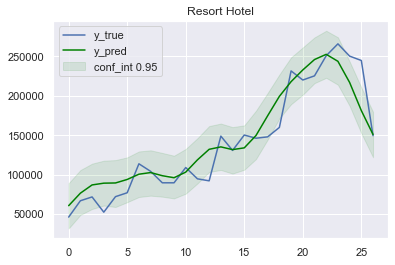

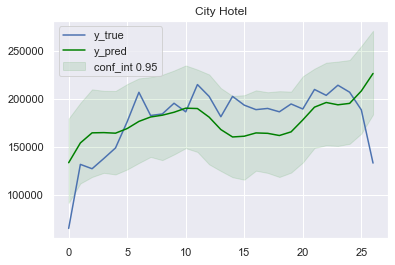

CPU times: user 1.69 s, sys: 180 ms, total: 1.87 s
Wall time: 4.11 s


In [5]:
%%time
res_prop = None

for hotel in uniq_hotels:
    df_filter = df[(df['hotel'] == hotel) & (df['is_canceled'] == 0)]
    
    #sample preparation
    train = df_filter[df_filter['is_train'] == 1]
    train = prepare_ts_for_modeling(data=train, groupby_date_col=GROUPBY_DATE_COL, target=TARGET, method_agg=METHOD_AGG)
    start_train = datetime.strptime('-W'.join(train['ds'].min().split('-')) + '-1', "%Y-W%W-%w")
    train['ds'] = pd.date_range(start_train, periods=train.shape[0], freq='W')
    
    test = df_filter[df_filter['is_train'] == 0]
    test = prepare_ts_for_modeling(data=test, groupby_date_col=GROUPBY_DATE_COL, target=TARGET, method_agg=METHOD_AGG)
    start_test = datetime.strptime('-W'.join(test['ds'].min().split('-')) + '-1', "%Y-W%W-%w")
    test['ds'] = pd.date_range(start_test, periods=test.shape[0], freq='W')
    #otherwise index is like from 0 to len(test) and it breaks prophet prediction
    test.index = list(range(train.index[-1] + 1, train.index[-1] + 1 + test.shape[0]))
    
    #omit tuning params and set some basic(sure, in case little amount of hotels we are able to do it with Optuna as example)
    #if there're lots of time series (hundreds of hotels) then we could get best by some series 
    prophet = Prophet(yearly_seasonality=True,
                  weekly_seasonality=False, # True for when both canceled and not canceled transactions used is better
                  daily_seasonality=False,
                  interval_width=ALPHA, #we need confidence interval
                  seasonality_mode='additive'
                 )
    prophet.fit(train)
    periods = test.shape[0]
    forecast = prophet.predict(prophet.make_future_dataframe(periods=periods, freq='W'))
    #forecast = forecast[-periods:]
    
    #creating result df
    tmp_df = pd.DataFrame({'hotel': [hotel] * (len(train) + len(test)),
                           'is_train': [1] * len(train) + [0] * len(test),
                           'y': train['y'].tolist() + test['y'].tolist(),
                           'yhat_prop': forecast['yhat'].tolist(),
                           'yhat_lower_prop': forecast['yhat_lower'].tolist(),
                           'yhat_upper_prop': forecast['yhat_upper'].tolist()
                          })
    res_prop = tmp_df if res_prop is None else pd.concat([res_prop, tmp_df])
res_prop = res_prop.reset_index(drop=True)

#plot all ts they are quite good
#for hotel in uniq_hotels:
#    tmp = res_prop[res_prop['hotel'] == hotel].reset_index(drop=True)
#    x = range(0, len(tmp))
#    plt.plot(x, tmp['y'], label=f"y_true")
#    plt.plot(x, tmp['yhat_prop'], label=f"y_pred", color='green')
#    plt.title(hotel)
#    plt.legend()
#    plt.show()
  
#plot test ts with conf int
for hotel in uniq_hotels:
    tmp = res_prop[(res_prop['hotel'] == hotel) & (res_prop['is_train'] == 0)].reset_index(drop=True)
    x = range(0, len(tmp))
    plt.plot(x, tmp['y'], label=f"y_true")
    plt.fill_between(x, tmp['yhat_upper_prop'], tmp['yhat_lower_prop'], color='green', alpha=0.1, label=f'conf_int {ALPHA}')
    plt.plot(x, tmp['yhat_prop'], label=f"y_pred", color='green')
    plt.title(hotel)
    plt.legend()
    plt.show()

The final goal is to predict 6-month revenue so lets aggregate it

In [6]:
print(f"true:\n{res_prop.groupby('hotel')['y'].sum()}")
print(f"pred:\n{res_prop.groupby('hotel')['yhat_prop'].sum().apply(lambda x: round(x, 2))}")

true:
hotel
City Hotel      14393956.28
Resort Hotel    11601350.53
Name: y, dtype: float64
pred:
hotel
City Hotel      14323997.75
Resort Hotel    11715347.25
Name: yhat_prop, dtype: float64


In [7]:
#metrics for PREDICTION_MONTHS size of target based on hotels the dataset includes
d = {}
for hotel in uniq_hotels:
    res_agg = res_prop[res_prop['hotel']==hotel].groupby('hotel').sum()
    d[hotel] = get_metrics(res_agg['y'], res_agg['yhat_prop'])
    print(f"{hotel}: {d[hotel]}")
    
res_agg = res_prop.groupby('hotel').sum()
d['All'] = get_metrics(res_agg['y'], res_agg['yhat_prop'])
print(f"All: {d['All']}")
metrics_d['Prophet'] = d

Resort Hotel: {'RMSE': 113996.71660484187, 'MAE': 113996.71660484187, 'MAPE': 0.009826159145011358}
City Hotel: {'RMSE': 69958.52700011618, 'MAE': 69958.52700011618, 'MAPE': 0.004860270910876782}
All: {'RMSE': 94576.54808860022, 'MAE': 91977.62180247903, 'MAPE': 0.00734321502794407}


**LSTM**

Create simple LSTM model

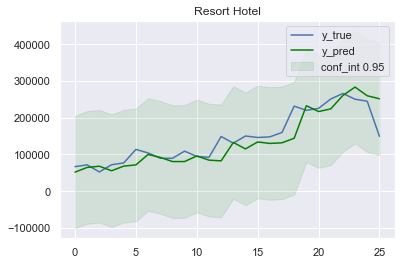

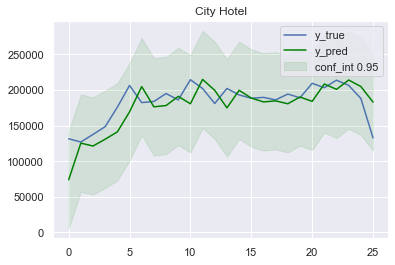

In [8]:
res_lstm = None

for hotel in uniq_hotels:
    df_filter = df[(df['hotel'] == hotel) & (df['is_canceled'] == 0)]
    train = df_filter[df_filter['is_train'] == 1]
    train = prepare_ts_for_modeling(data=train, groupby_date_col=GROUPBY_DATE_COL, target=TARGET, method_agg=METHOD_AGG)
    train = train['y'].values.reshape(-1, 1)
    

    test = df_filter[df_filter['is_train'] == 0]
    test = prepare_ts_for_modeling(data=test, groupby_date_col=GROUPBY_DATE_COL, target=TARGET, method_agg=METHOD_AGG)
    test = test['y'].values.reshape(-1, 1)
    
    #since lstm is sensitive to the scale, need to to transform
    scaler = MinMaxScaler() #better than StandardScaler
    train_sc = scaler.fit_transform(train)
    test_sc = scaler.transform(test)
    
    n_steps = 1
    Xtrain, ytrain = create_dataset(train_sc, n_steps)
    Xtest, ytest = create_dataset(test_sc, n_steps)

    n_features = 1
    Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], n_features)
    Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], n_features)

    np.random.seed(777)

    model_lstm = Sequential()
    opt = Adam(learning_rate=0.0003) #0.0003 is considering a really good for Adam bit it'll take much more time

    #LSTM
    model_lstm.add(Bidirectional(LSTM(30, activation='relu', return_sequences=True
                        , input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
    model_lstm.add(Bidirectional(LSTM(5, activation='relu')))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer=opt, loss='mse')

    history = model_lstm.fit(Xtrain, ytrain, epochs=100, batch_size=1, shuffle=False, use_multiprocessing=True
                       , validation_data=(Xtest, ytest), verbose=0)

    yhat_train_lstm = model_lstm.predict(Xtrain)
    yhat_test_lstm = model_lstm.predict(Xtest)
    #inverse to got true values
    yhat_train_lstm = scaler.inverse_transform(yhat_train_lstm)
    yhat_test_lstm = scaler.inverse_transform(yhat_test_lstm)
    
    #creating result df
    tmp_df = pd.DataFrame({'hotel': [hotel] * (len(train) + len(test) - 2 * n_steps),
                           'is_train': [1] * (len(train) - n_steps) + [0] * (len(test) - n_steps),
                           'y': np.hstack([train.squeeze()[n_steps:], test.squeeze()[n_steps:]]),
                           'yhat_lstm': np.hstack([yhat_train_lstm.squeeze(), yhat_test_lstm.squeeze()])
                          })
    
    y_lower, y_upper = get_prediction_inerval(yhat_train_lstm, ALPHA)
    yhat_lower, yhat_upper = get_prediction_inerval(yhat_test_lstm, ALPHA)
    tmp_df['yhat_lower_lstm'] = np.hstack([y_lower.squeeze(), yhat_lower.squeeze()])
    tmp_df['yhat_upper_lstm'] = np.hstack([y_upper.squeeze(), yhat_upper.squeeze()])
    
    res_lstm = tmp_df if res_lstm is None else pd.concat([res_lstm, tmp_df])
    
res_lstm = res_lstm.reset_index(drop=True)   

#plot all ts they are quite good
#for hotel in uniq_hotels:
#    tmp = res_lstm[res_lstm['hotel'] == hotel].reset_index(drop=True)
#    x = range(0, len(tmp))
#    plt.plot(x, tmp['y'], label=f"y_true")
#    plt.plot(x, tmp['yhat_lstm'], label=f"y_pred", color='green')
#    plt.title(hotel)
#    plt.legend()
#    plt.show()
  
#plot test ts with conf int
for hotel in uniq_hotels:
    tmp = res_lstm[(res_lstm['hotel'] == hotel) & (res_lstm['is_train'] == 0)].reset_index(drop=True)
    x = range(0, len(tmp))
    plt.plot(x, tmp['y'], label=f"y_true")
    plt.fill_between(x, tmp['yhat_upper_lstm'], tmp['yhat_lower_lstm'], color='green', alpha=0.1, label=f'conf_int {ALPHA}')
    plt.plot(x, tmp['yhat_lstm'], label=f"y_pred", color='green')
    plt.title(hotel)
    plt.legend()
    plt.show()

In [9]:
print(f"true:\n{res_lstm.groupby('hotel')['y'].sum()}")
print(f"pred:\n{res_lstm.groupby('hotel')['yhat_lstm'].sum().apply(lambda x: round(x, 2))}")

true:
hotel
City Hotel      14311875.45
Resort Hotel    11487077.70
Name: y, dtype: float64
pred:
hotel
City Hotel      14344286.0
Resort Hotel    11221337.0
Name: yhat_lstm, dtype: float64


In [10]:
#metrics for PREDICTION_MONTHS size of target based on hotels the dataset includes
d = {}
for hotel in uniq_hotels:
    res_agg = res_lstm[res_lstm['hotel']==hotel].groupby('hotel').sum()
    d[hotel] = get_metrics(res_agg['y'], res_agg['yhat_lstm'])
    print(f"{hotel}: {d[hotel]}")
    
res_agg = res_lstm.groupby('hotel').sum()
d['All'] = get_metrics(res_agg['y'], res_agg['yhat_lstm'])
print(f"All: {d['All']}")
metrics_d['LSTM'] = d

Resort Hotel: {'RMSE': 265740.69999999925, 'MAE': 265740.69999999925, 'MAPE': 0.023133881996811014}
City Hotel: {'RMSE': 32410.54999999702, 'MAE': 32410.54999999702, 'MAPE': 0.002264591395671838}
All: {'RMSE': 189299.44979818605, 'MAE': 149075.62499999814, 'MAPE': 0.012699236696241427}


**Boosting**

Here the thought is about to try something more complicated. We need to aggregate target by 6 months and the task is about prediction from the 1st day of the month + 6 months so step back 1 day from that day and create window features. Size of windows can be almost any. For the task I will be based on lead_time to decide how many days i need (maybe 30 days but maybe 180), anyway it should be tested.

As i pointed out there're only two hotels in data and quite little amount of data so if we had more hotels (cos they are objects) and data we could build a really powerfull ML model on CatBoost, for instance

In [11]:
df['lead_time'].describe()

count    117422.000000
mean        105.089642
std         106.908354
min           0.000000
25%          19.000000
50%          71.000000
75%         162.000000
max         709.000000
Name: lead_time, dtype: float64

I'd create features using windows 60, 90, 180 days

**To Sum up**

In [12]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in metrics_d.items()
          for innerKey, values in innerDict.items()
         }
pd.DataFrame(reform)

Prophet                                      LSTM                \
       Resort Hotel   City Hotel           All   Resort Hotel    City Hotel   
RMSE  113996.716605  69958.52700  94576.548089  265740.700000  32410.550000   
MAE   113996.716605  69958.52700  91977.621802  265740.700000  32410.550000   
MAPE       0.009826      0.00486      0.007343       0.023134      0.002265   

                     
                All  
RMSE  189299.449798  
MAE   149075.625000  
MAPE       0.012699

Here was tested 2 different models BiLSTM (since it's usually better than ordinary LSTM due to bideractional studying) and Prophet, also here's a small my opinion about using SARIMA in the beginig

The task was to predict K-month revenue per hotel and K in the casi is 6. There're only two hotels in dataset and about 2 years of daily booking transaction data.

Here was shown that generating data with features to predict hotels revenue isn't a good idea due to having only two hotels and quite little amount of data and that data is good to predict cancellation per transaction or adt or staying_nights or how much money clients spend for some period for example 6-month too but there's no id of clients. So it's no really good data to predict hotels' revenue.

We see that Prophet model is better based on metrics but LSTM is much better in guessing of time series moving so it's better behave like a true data and LSTM has a lot of options to tune and get better and better results. But Propet is easier to deploy and fit especially in case of growing amount of hotels cos it can quite easy fit data without difficult settings and it trains much faster. So if we have like 1-5 ts maybe it's okay to use LSTM and set parameters carefully but if we have more than 100 time series then Prophet is our choice in this case